<a href="https://colab.research.google.com/github/Vaniza/2206-fundamentos-js/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

In [10]:
# Definições
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
DATASET_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
DATASET_PATH = keras.utils.get_file("cats_and_dogs_filtered.zip", DATASET_URL, extract=False)
DATA_DIR = os.path.join(os.path.dirname(DATASET_PATH), "cats_and_dogs_filtered")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALIDATION_DIR = os.path.join(DATA_DIR, "validation")

In [11]:
# Extrair o conjunto de dados caso ainda não esteja extraído
if not os.path.exists(DATA_DIR):
    with zipfile.ZipFile(DATASET_PATH, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(DATASET_PATH))

In [12]:
# Verifica se os diretórios existem
if not os.path.exists(TRAIN_DIR) or not os.path.exists(VALIDATION_DIR):
    raise FileNotFoundError("Os diretórios de treinamento ou validação não foram encontrados. Verifique se o dataset foi extraído corretamente.")


In [13]:
# Pré-processamento dos dados
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              target_size=IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
# Carregar modelo pré-treinado VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Congelar camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False

In [16]:
# Criar nova cabeça de rede
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Saída binária (gato ou cachorro)

In [17]:
# Criar modelo final
model = Model(inputs=base_model.input, outputs=x)

In [18]:
# Compilar modelo
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
# Treinar modelo
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1879s 30s/step - accuracy: 0.6349 - loss: 0.6720 - val_accuracy: 0.8800 - val_loss: 0.2860
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1812s 29s/step - accuracy: 0.8174 - loss: 0.4021 - val_accuracy: 0.8950 - val_loss: 0.2497
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1810s 29s/step - accuracy: 0.8426 - loss: 0.3411 - val_accuracy: 0.8990 - val_loss: 0.2332
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1819s 29s/step - accuracy: 0.8631 - loss: 0.3250 - val_accuracy: 0.9200 - val_loss: 0.2167
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1811s 29s/step - accuracy: 0.8588 - loss: 0.3256 - val_accuracy: 0.9240 - val_loss: 0.2064
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1809s 29s/step - accuracy: 0.8684 - loss: 0.3202 - val_accuracy: 0.9260 - val_loss: 0.1985
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1806s 29s/step - accuracy: 0.8642 - loss: 0.3110 - val_accuracy: 0.9020 - val_loss: 0.2321
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1838s 29s/step - accuracy: 0.8678 - loss: 0.2916 - val_accu

In [20]:
# Avaliar modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

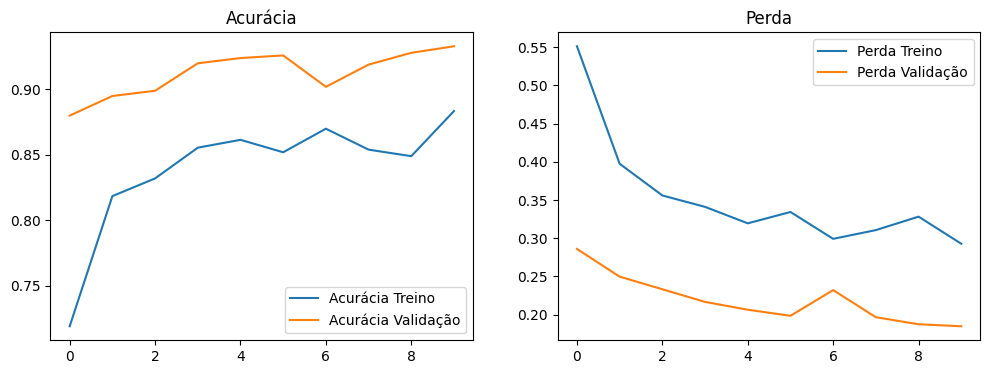

In [21]:
# Plotar resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Acurácia Treino')
plt.plot(val_acc, label='Acurácia Validação')
plt.legend()
plt.title('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Perda Treino')
plt.plot(val_loss, label='Perda Validação')
plt.legend()
plt.title('Perda')

plt.show()

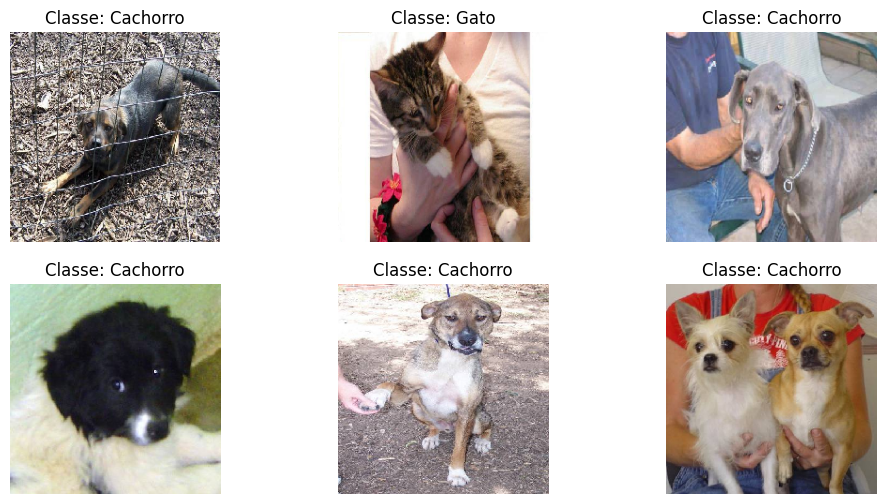

In [22]:
# Obter um lote de imagens do conjunto de validação
images, labels = next(validation_generator)

# Exibir algumas imagens
plt.figure(figsize=(12, 6))

for i in range(6):  # Mostrar 6 imagens
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])  # Mostrar a imagem
    plt.title(f'Classe: {"Cachorro" if labels[i] > 0.5 else "Gato"}')
    plt.axis('off')

plt.show()